In [1]:
from tensorflow import keras
from keras.models import Sequential
from keras.datasets import mnist
import numpy as np
import matplotlib
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam


font = {'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

# **1. Data treatment**
## **1.1 Loading training data**

First, we load the datasets and their corresponding labels, and display an image to verify that the data has been loaded correctly.

In [2]:
from google.colab import drive
import os
import re
import pandas as pd


train_data_directory = "/content/drive/MyDrive/Colab Notebooks/projet/MPA-MLF_DATA_NEW/Train"
train_file_list=sorted(os.listdir(train_data_directory), key=lambda x:int(re.search(r'\d+', x).group())) #list containing the names of the files in the directory : train_data_directory (in numerical order).
X = [np.load(os.path.join(train_data_directory, file)) for file in train_file_list] #load all .npy files into a list

y = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/projet/MPA-MLF_DATA_NEW/label_train.csv') #label
y = y['target'] #get only the target

print(f"Total files loaded: {len(X)}") #to be sure that all files are loaded, must be 1491
print(f"Shape of first file: {X[0].shape}") #to verify the shape of the files, must be (72,48)
print(y.shape[0:4])



Total files loaded: 1491
Shape of first file: (72, 48)
(1491,)


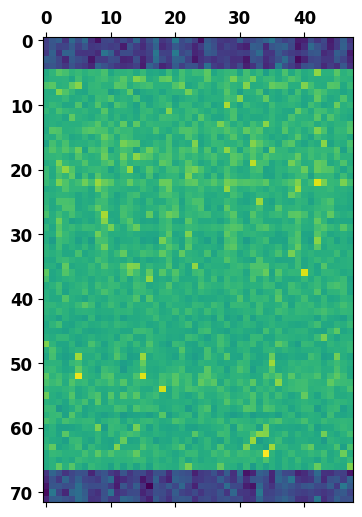

In [3]:
plt.matshow(X[0])

We now set a random seed to make model comparisons consistent and reproducible.

In [4]:
tf.config.experimental.enable_op_determinism()
tf.random.set_seed(12022003)

We convert the list into an array to facilitate preprocessing and splitting into training and testing sets.

(1043, 72, 48)
(448, 72, 48)
(1043,)
(448,)


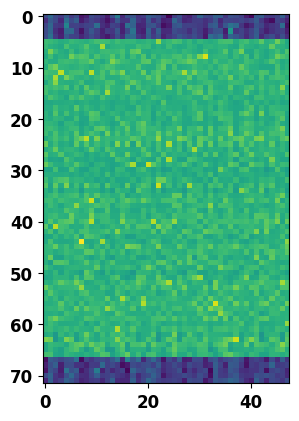

In [5]:
#convertion
X=np.asarray(X)
y=np.asarray(y)

#train/test split with sklearn
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)


print(X_train.shape) #must be (1043, 72, 48)
print(X_test.shape) #must be (448, 72, 48)
print(y_train.shape) #must be (1043,)
print(y_test.shape) #must be (448,)
plt.imshow(X_train[0]) #display image to verify it is still correct

## **1.2 Dataset examination**

Analysis of the distribution of target classes.

In [6]:
print(np.sum(y == 0))
print(np.sum(y == 1))
print(np.sum(y == 2))

1209
141
141


The dataset is highly imbalanced so technique such data augmentation could later be considered to improve model performance.

## **1.3 Dataset preprocessing**

The best way to preprocess the data would be one hot encoding for the target variable and normalization for the input variable using min-max normalization.

In [7]:
###################################
#Normalize the data to a range of 0 to 1 (divide by 255 as pixel intensities in gray scale images range from 0 to 255)
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

#Reshape the data to add a channel dimension (for CNN input)
X_train=X_train.reshape(-1,72,48,1)
X_test=X_test.reshape(-1,72,48,1)

#one-hot encode the labels
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

print(X_train[0].shape)
print(X_test[0].shape)
print(y_train[0])
print(y_test[0])

(72, 48, 1)
(72, 48, 1)
[1. 0. 0.]
[1. 0. 0.]


# **2. First model**

### **2.1 Model structure**
The chosen model is a Convolutional Neural Network (CNN). For a first try, we implemented a simple model to test the dataset, based on the architecture of the last model of the CNN lab. The model structure was as follows:
- One convolutional layer with 32 filters, a 3x3 kernel, and ReLU activation
- One max pooling layer to reduce the spatial dimensions
- One flattening layer to prepare the data for the fully connected layers
- One fully connected (dense) layer with 128 neurons and ReLU activation
- One output layer with softmax activation for multi-class classification

In [8]:
model = Sequential()
###################################

#convolutionnal layer with 32 filters, 3x3 kernel, ReLU activation
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(72,48,1)))

#MaxPooling layer to reduce the spatial dimensions
model.add(MaxPooling2D(pool_size=(2, 2)))

#Flatten layer to prepare for the fully connected layers
model.add(Flatten())

#Fully connected layer with 128 neurons and ReLU activation
model.add(Dense(128, activation='relu'))

#output layer with softmax activation for multi-class classification
model.add(Dense(3, activation='softmax'))

###################################
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 70, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 35, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25760)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,297,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,298,115 (12.58 MB)

 Trainable params: 3,298,115 (12.58 MB)

 Non-trainable params: 0 (0.00 B)

##**2.2 Compile the model**

In [9]:
##################################
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
###################################

#**3. Training stage**

### **3.1 Model training**

In [10]:
###################################
history = model.fit(X_train, y_train, epochs=20, batch_size=100, validation_data=(X_test, y_test), verbose=2)
###################################

Epoch 1/20
11/11 - 6s - 505ms/step - accuracy: 0.7565 - loss: 0.6293 - val_accuracy: 0.7902 - val_loss: 0.5723
Epoch 2/20
11/11 - 4s - 369ms/step - accuracy: 0.8198 - loss: 0.4852 - val_accuracy: 0.7902 - val_loss: 0.5545
Epoch 3/20
11/11 - 3s - 267ms/step - accuracy: 0.8447 - loss: 0.4171 - val_accuracy: 0.8393 - val_loss: 0.4683
Epoch 4/20
11/11 - 5s - 436ms/step - accuracy: 0.8917 - loss: 0.3538 - val_accuracy: 0.8549 - val_loss: 0.4077
Epoch 5/20
11/11 - 3s - 240ms/step - accuracy: 0.9032 - loss: 0.2902 - val_accuracy: 0.8571 - val_loss: 0.3395
Epoch 6/20
11/11 - 3s - 244ms/step - accuracy: 0.9051 - loss: 0.2249 - val_accuracy: 0.8594 - val_loss: 0.2650
Epoch 7/20
11/11 - 3s - 276ms/step - accuracy: 0.9147 - loss: 0.1643 - val_accuracy: 0.9085 - val_loss: 0.2023
Epoch 8/20
11/11 - 5s - 429ms/step - accuracy: 0.9732 - loss: 0.1154 - val_accuracy: 0.9688 - val_loss: 0.1570
Epoch 9/20
11/11 - 3s - 271ms/step - accuracy: 0.9904 - loss: 0.0824 - val_accuracy: 0.9799 - val_loss: 0.1224
E

## **3.2 Model Evaluation on validation data**
To evaluate the model on the validation data, we plot the loss and accuracy over the epochs, along with the confusion matrix.

Accuracy: 98.21
Loss: 5.07


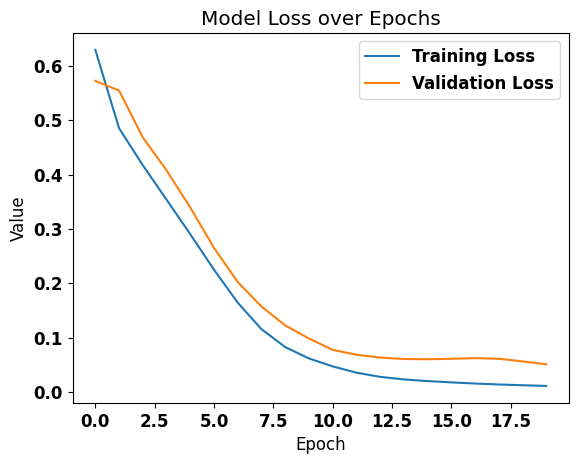

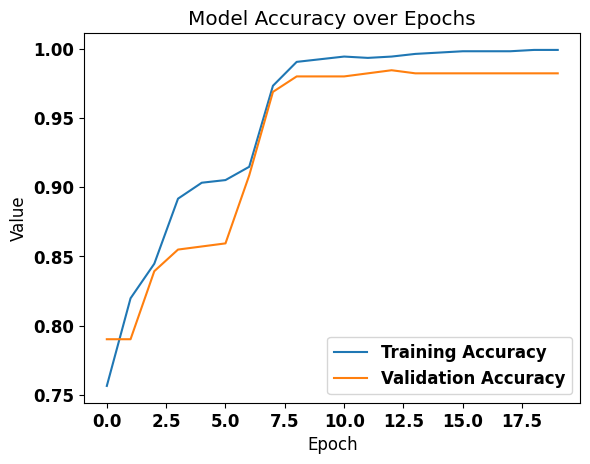

In [11]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy: {:.2f}'.format(accuracy*100))
print('Loss: {:.2f}'.format(loss*100))
fig, ax = plt.subplots()
ax.plot(history.history['loss'], label='Training Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.set_ylabel('Value')
ax.set_xlabel('Epoch')
ax.set_title('Model Loss over Epochs')
ax.legend()
plt.show()

fig, ay = plt.subplots()
ay.plot(history.history['accuracy'], label='Training Accuracy')
ay.plot(history.history['val_accuracy'], label='Validation Accuracy')
ay.set_ylabel('Value')
ay.set_xlabel('Epoch')
ay.set_title('Model Accuracy over Epochs')
ay.legend()
plt.show()


###################################

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


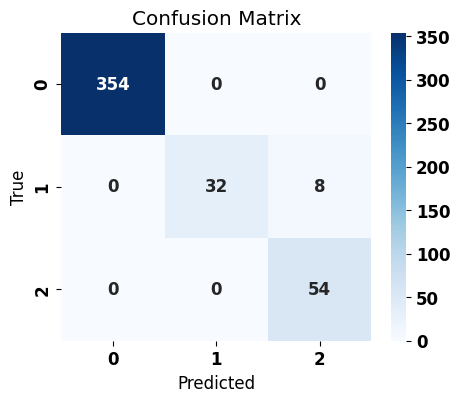

In [12]:
###################################
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns

#List of class labels
labels=['0', '1', '2']

#Make predictions on the test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1) #convert predictions to class labels

#Get true class labels
y_true = np.argmax(y_test, axis=1)

#compute the confusion matrix
cm=confusion_matrix(y_true, y_pred_classes)

#plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()





###################################

 **commenter résultats**

#**4. Improve model performance**

## **4.1 data augmentation : rotation and flipping**

Given the limited size of the original dataset, data augmentation techniques were applied to artificially increase the number of training samples.

In [13]:
def augment_flips(X, y):
    X_augmented = []
    y_augmented = []

    for i in range(len(X)):
        img = X[i]
        label = y[i]

        #Add original image
        X_augmented.append(img)
        y_augmented.append(label)

        #Horizontal flip
        X_augmented.append(np.fliplr(img))
        y_augmented.append(label)

        #Vertical flip
        X_augmented.append(np.flipud(img))
        y_augmented.append(label)

        #Horizontal + vertical flip
        X_augmented.append(np.flipud(np.fliplr(img)))
        y_augmented.append(label)

    return np.array(X_augmented), np.array(y_augmented)

#Data augmentation performed only on the trainin datas
X_train_inc, y_train_inc = augment_flips(X_train, y_train) #save the increased X and y in new variable in case the data augmentation is not very effective

print(X_train_inc.shape)
print(y_train_inc.shape)


(4172, 72, 48, 1)
(4172, 3)


We now use the same model as before, but with more input data, to see if it improves performance.

In [14]:
model = Sequential()
###################################

#convolutionnal layer with 32 filters, 3x3 kernel, ReLU activation
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(72,48,1)))

#MaxPooling layer to reduce the spatial dimensions
model.add(MaxPooling2D(pool_size=(2, 2)))

#Flatten layer to prepare for the fully connected layers
model.add(Flatten())

#Fully connected layer with 128 neurons and ReLU activation
model.add(Dense(128, activation='relu'))

#output layer with softmax activation for multi-class classification
model.add(Dense(3, activation='softmax'))

model.summary()

###################################
#compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

###################################

###################################
history = model.fit(X_train_inc, y_train_inc, epochs=20, batch_size=100, validation_data=(X_test, y_test), verbose=2)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 70, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 35, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25760)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,297,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,298,115 (12.58 MB)

 Trainable params: 3,298,115 (12.58 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
42/42 - 14s - 324ms/step - accuracy: 0.8236 - loss: 0.4713 - val_accuracy: 0.8504 - val_loss: 0.4810
Epoch 2/20
42/42 - 14s - 330ms/step - accuracy: 0.9012 - loss: 0.2933 - val_accuracy: 0.8594 - val_loss: 0.3233
Epoch 3/20
42/42 - 19s - 459ms/step - accuracy: 0.9573 - loss: 0.1310 - val_accuracy: 0.9643 - val_loss: 0.1206
Epoch 4/20
42/42 - 11s - 270ms/step - accuracy: 0.9899 - loss: 0.0593 - val_accuracy: 0.9688 - val_loss: 0.0882
Epoch 5/20
42/42 - 12s - 274ms/step - accuracy: 0.9921 - loss: 0.0394 - val_accuracy: 0.9732 - val_loss: 0.0807
Epoch 6/20
42/42 - 12s - 296ms/step - accuracy: 0.9933 - loss: 0.0287 - val_accuracy: 0.9777 - val_loss: 0.0720
Epoch 7/20
42/42 - 10s - 239ms/step - accuracy: 0.9942 - loss: 0.0231 - val_accuracy: 0.9799 - val_loss: 0.0676
Epoch 8/20
42/42 - 11s - 266ms/step - accuracy: 0.9947 - loss: 0.0199 - val_accuracy: 0.9799 - val_loss: 0.0671
Epoch 9/20
42/42 - 12s - 274ms/step - accuracy: 0.9935 - loss: 0.0203 - val_accuracy: 0.9799 - val_loss:

Accuracy: 97.99
Loss: 4.68


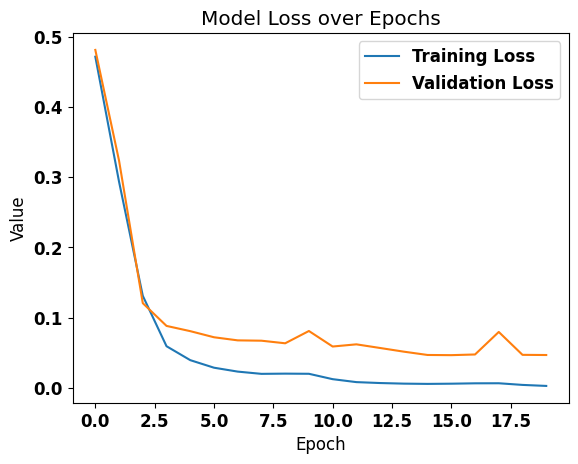

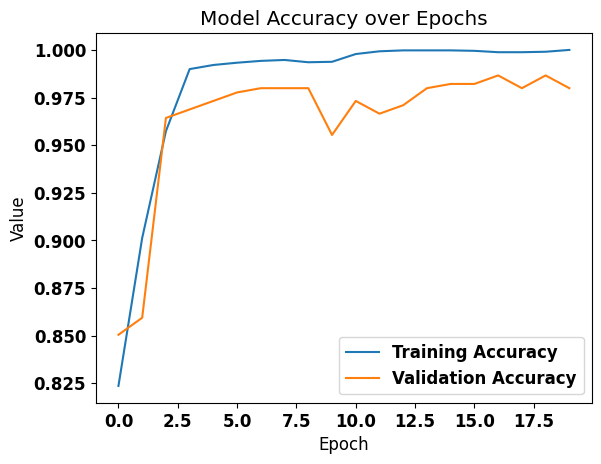

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


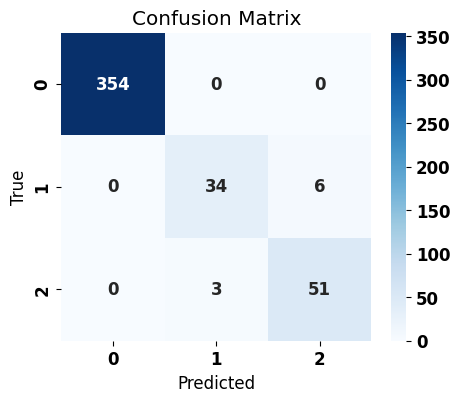

In [15]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy: {:.2f}'.format(accuracy*100))
print('Loss: {:.2f}'.format(loss*100))

fig, ax = plt.subplots()
ax.plot(history.history['loss'], label='Training Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.set_ylabel('Value')
ax.set_xlabel('Epoch')
ax.set_title('Model Loss over Epochs')
ax.legend()
plt.show()

fig, ay = plt.subplots()
ay.plot(history.history['accuracy'], label='Training Accuracy')
ay.plot(history.history['val_accuracy'], label='Validation Accuracy')
ay.set_ylabel('Value')
ay.set_xlabel('Epoch')
ay.set_title('Model Accuracy over Epochs')
ay.legend()
plt.show()

#List of class labels
labels=['0', '1', '2']

#Make predictions on the test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1) #convert predictions to class labels

#Get true class labels
y_true = np.argmax(y_test, axis=1)

#compute the confusion matrix
cm=confusion_matrix(y_true, y_pred_classes)

#plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

 **commenter résultats**

## **4.2 Model structure improvement**
Next, we introduce an additional convolutional layer, followed by a max-pooling layer.


In [16]:
model = Sequential()
###################################

#convolutionnal layer with 32 filters, 3x3 kernel, ReLU activation
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(72,48,1)))

#MaxPooling layer to reduce the spatial dimensions
model.add(MaxPooling2D(pool_size=(2, 2)))

#convolutionnal layer with 32 filters, 3x3 kernel, ReLU activation
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(72,48,1)))

#MaxPooling layer to reduce the spatial dimensions
model.add(MaxPooling2D(pool_size=(2, 2)))

#Flatten layer to prepare for the fully connected layers
model.add(Flatten())

#Fully connected layer with 128 neurons and ReLU activation
model.add(Dense(128, activation='relu'))

#output layer with softmax activation for multi-class classification
model.add(Dense(3, activation='softmax'))

model.summary()

###################################
#compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

###################################

###################################
history = model.fit(X_train_inc, y_train_inc, epochs=20, batch_size=100, validation_data=(X_test, y_test), verbose=2)

###################################

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 70, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 35, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 33, 21, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 5120)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       655,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 665,443 (2.54 MB)

 Trainable params: 665,443 (2.54 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
42/42 - 17s - 400ms/step - accuracy: 0.8020 - loss: 0.5590 - val_accuracy: 0.8304 - val_loss: 0.5416
Epoch 2/20
42/42 - 20s - 483ms/step - accuracy: 0.8969 - loss: 0.3606 - val_accuracy: 0.8594 - val_loss: 0.4412
Epoch 3/20
42/42 - 21s - 495ms/step - accuracy: 0.9108 - loss: 0.2518 - val_accuracy: 0.8705 - val_loss: 0.2437
Epoch 4/20
42/42 - 15s - 348ms/step - accuracy: 0.9513 - loss: 0.1491 - val_accuracy: 0.9554 - val_loss: 0.1165
Epoch 5/20
42/42 - 15s - 345ms/step - accuracy: 0.9803 - loss: 0.0707 - val_accuracy: 0.9754 - val_loss: 0.0747
Epoch 6/20
42/42 - 15s - 349ms/step - accuracy: 0.9892 - loss: 0.0456 - val_accuracy: 0.9821 - val_loss: 0.0618
Epoch 7/20
42/42 - 14s - 342ms/step - accuracy: 0.9909 - loss: 0.0377 - val_accuracy: 0.9799 - val_loss: 0.0602
Epoch 8/20
42/42 - 14s - 341ms/step - accuracy: 0.9907 - loss: 0.0343 - val_accuracy: 0.9799 - val_loss: 0.0598
Epoch 9/20
42/42 - 21s - 491ms/step - accuracy: 0.9919 - loss: 0.0315 - val_accuracy: 0.9821 - val_loss:

Accuracy: 97.99
Loss: 6.13


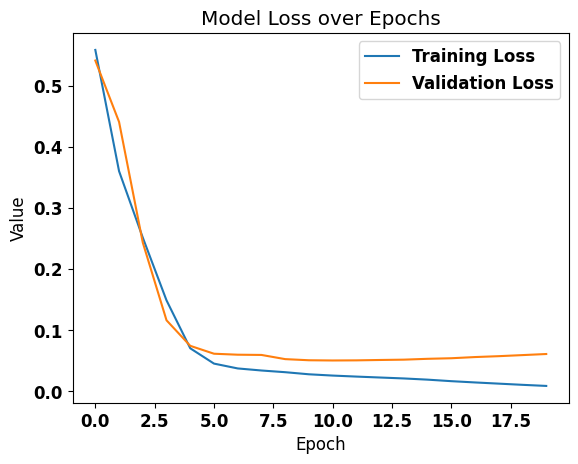

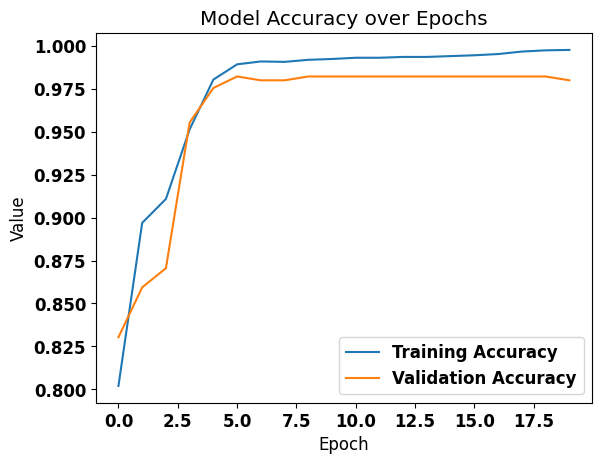

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


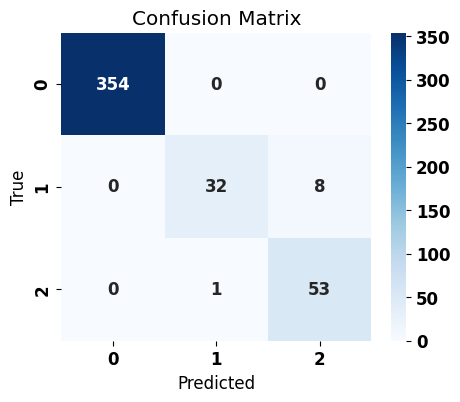

In [17]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy: {:.2f}'.format(accuracy*100))
print('Loss: {:.2f}'.format(loss*100))

fig, ax = plt.subplots()
ax.plot(history.history['loss'], label='Training Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.set_ylabel('Value')
ax.set_xlabel('Epoch')
ax.set_title('Model Loss over Epochs')
ax.legend()
plt.show()

fig, ay = plt.subplots()
ay.plot(history.history['accuracy'], label='Training Accuracy')
ay.plot(history.history['val_accuracy'], label='Validation Accuracy')
ay.set_ylabel('Value')
ay.set_xlabel('Epoch')
ay.set_title('Model Accuracy over Epochs')
ay.legend()
plt.show()

#List of class labels
labels=['0', '1', '2']

#Make predictions on the test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1) #convert predictions to class labels

#Get true class labels
y_true = np.argmax(y_test, axis=1)

#compute the confusion matrix
cm=confusion_matrix(y_true, y_pred_classes)

#plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**COMMENTER RESULTATS**

## **4.3 L2 Regularization and dropout**
We now applied two regularization techniques: L2 regularization and dropout

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 - 17s - 413ms/step - accuracy: 0.8097 - loss: 0.6950 - val_accuracy: 0.7902 - val_loss: 0.6137
Epoch 2/20
42/42 - 20s - 470ms/step - accuracy: 0.8787 - loss: 0.4151 - val_accuracy: 0.8594 - val_loss: 0.4175
Epoch 3/20
42/42 - 20s - 487ms/step - accuracy: 0.9192 - loss: 0.2524 - val_accuracy: 0.9442 - val_loss: 0.1871
Epoch 4/20
42/42 - 15s - 364ms/step - accuracy: 0.9609 - loss: 0.1538 - val_accuracy: 0.9688 - val_loss: 0.1199
Epoch 5/20
42/42 - 15s - 352ms/step - accuracy: 0.9784 - loss: 0.1023 - val_accuracy: 0.9799 - val_loss: 0.0984
Epoch 6/20
42/42 - 15s - 351ms/step - accuracy: 0.9823 - loss: 0.0855 - val_accuracy: 0.9821 - val_loss: 0.0873
Epoch 7/20
42/42 - 21s - 491ms/step - accuracy: 0.9832 - loss: 0.0732 - val_accuracy: 0.9799 - val_loss: 0.0861
Epoch 8/20
42/42 - 14s - 344ms/step - accuracy: 0.9830 - loss: 0.0758 - val_accuracy: 0.9821 - val_loss: 0.0840
Epoch 9/20
42/42 - 21s - 494ms/step - accuracy: 0.9830 - loss: 0.0716 - val_accuracy: 0.9732 - val_loss: 0.0875
Epo

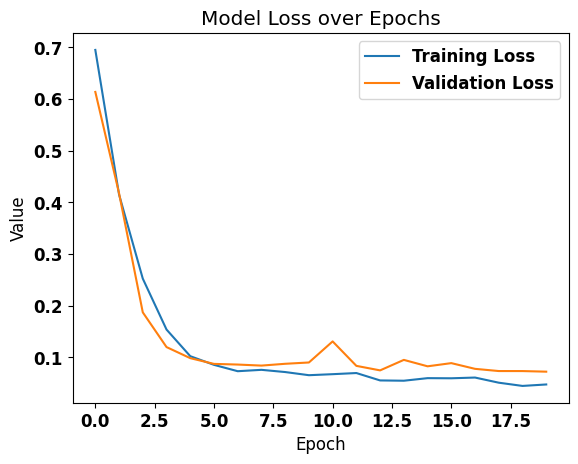

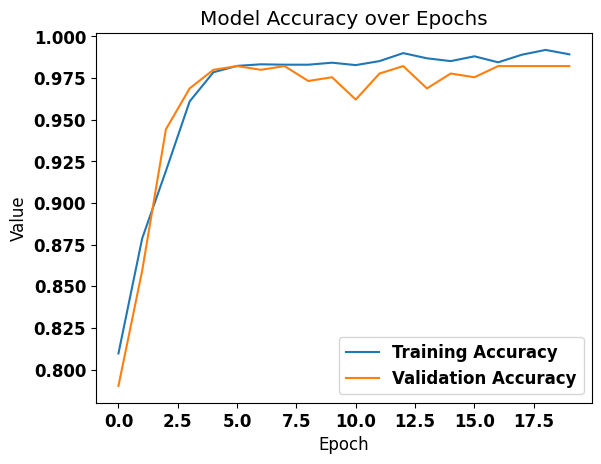

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


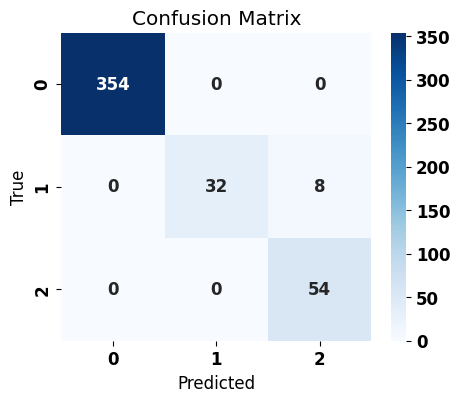

In [18]:
from tensorflow.keras import regularizers

model = Sequential()

#convolutionnal layer with 32 filters, 3x3 kernel, ReLU activation
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(72,48,1)))

#MaxPooling layer to reduce the spatial dimensions
model.add(MaxPooling2D(pool_size=(2, 2)))

#convolutionnal layer with 32 filters, 3x3 kernel, ReLU activation
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(72,48,1)))

#MaxPooling layer to reduce the spatial dimensions
model.add(MaxPooling2D(pool_size=(2, 2)))

#Flatten layer to prepare for the fully connected layers
model.add(Flatten())

#dense avec L2 + Dropout
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.5))

#Fully connected layer with 128 neurons and ReLU activation
model.add(Dense(128, activation='relu'))

#output layer with softmax activation for multi-class classification
model.add(Dense(3, activation='softmax'))

#compile
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

#training
history = model.fit(X_train_inc, y_train_inc, epochs=20, batch_size=100, validation_data=(X_test, y_test), verbose=2)

loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy: {:.2f}'.format(accuracy*100))
print('Loss: {:.2f}'.format(loss*100))

fig, ax = plt.subplots()
ax.plot(history.history['loss'], label='Training Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.set_ylabel('Value')
ax.set_xlabel('Epoch')
ax.set_title('Model Loss over Epochs')
ax.legend()
plt.show()

fig, ay = plt.subplots()
ay.plot(history.history['accuracy'], label='Training Accuracy')
ay.plot(history.history['val_accuracy'], label='Validation Accuracy')
ay.set_ylabel('Value')
ay.set_xlabel('Epoch')
ay.set_title('Model Accuracy over Epochs')
ay.legend()
plt.show()

#List of class labels
labels=['0', '1', '2']

#Make predictions on the test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1) #convert predictions to class labels

#Get true class labels
y_true = np.argmax(y_test, axis=1)

#compute the confusion matrix
cm=confusion_matrix(y_true, y_pred_classes)

#plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()




# **5. Hyperparameter tunning**

## **5.1 Grid search**
Selecting the appropriate hyperparameters is essential for optimizing machine learning model performance, so we applied the grid search algorithm to find the best combination.






In [20]:
#Range of changing parameters
nb_neurons = [150, 175,200]
#activations = ['relu', 'sigmoid'] #activations tested previously but 'sigmoid' did not perform well
dropout_rates = [0.2, 0.4, 0.6]
l2_reg_rates = [0.001, 0.01, 0.1]
nb_layers = [1, 2]


#Variable to memorize the best parameter
best_accuracy = 0
best_model = None
best_params = {}

# Grid search
for nb in nb_neurons:
    for drop in dropout_rates:
      for l2 in l2_reg_rates:
        for lay in nb_layers:
          print(f"Testing model with {lay} layer(s), nb of neutrons : {nb}, L2 rate: {l2} and dropout: {drop}")

          if lay == 1 :
            #model with 'one' layer
            model = Sequential()
            model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(72, 48, 1)))
            model.add(MaxPooling2D(pool_size=(2, 2)))
            model.add(Flatten())
            model.add(Dense(nb, activation='relu', kernel_regularizer=regularizers.l2(l2)))
            model.add(Dropout(drop))
            model.add(Dense(nb, activation='relu'))
            model.add(Dense(3, activation='softmax'))

          else:
            #model with 'two' layers
            model = Sequential()
            model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(72, 48, 1)))
            model.add(MaxPooling2D(pool_size=(2, 2)))
            model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(72, 48, 1)))
            model.add(MaxPooling2D(pool_size=(2, 2)))
            model.add(Flatten())
            model.add(Dense(nb, activation='relu', kernel_regularizer=regularizers.l2(l2)))
            model.add(Dropout(drop))
            model.add(Dense(nb, activation='relu'))
            model.add(Dense(3, activation='softmax'))


          # Compile actual model (with one or two layer(s))
          model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

          #train model
          history = model.fit(X_train_inc, y_train_inc, epochs=15, batch_size=100, validation_data=(X_test, y_test), verbose=2)

          #get the loss and accuracy and plot them against the number of epochs.
          loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
          fig, ax = plt.subplots()
          ax.plot(history.history['loss'], label='Training Loss')
          ax.plot(history.history['val_loss'], label='Validation Loss')
          ax.set_ylabel('Value')
          ax.set_xlabel('Epoch')
          ax.set_title('Model Loss over Epochs')
          ax.legend()
          plt.show()

          fig, ay = plt.subplots()
          ay.plot(history.history['accuracy'], label='Training Accuracy')
          ay.plot(history.history['val_accuracy'], label='Validation Accuracy')
          ay.set_ylabel('Value')
          ay.set_xlabel('Epoch')
          ay.set_title('Model Accuracy over Epochs')
          ay.legend()
          plt.show()

          #if accuracy is better, we save it into variables
          if accuracy > best_accuracy:
              best_accuracy = accuracy
              best_model = model
              best_params = {'nb_neurons' : nb, 'l2_rate': l2, 'dropout': drop, 'nb_layer' : lay}

print("\nBest Parameters found:")
print(best_params)
print(f"Best validation accuracy: {best_accuracy}")


Output hidden; open in https://colab.research.google.com to view.

# **Application of the Trained Model to New Data**

## **5.2 Epoch Number Optimization**
As discussed in the report, we now optimize the number of epochs to reduce the risk of overfitting.

Epoch 1/20
42/42 - 21s - 502ms/step - accuracy: 0.8032 - loss: 0.6963 - val_accuracy: 0.7902 - val_loss: 0.5679
Epoch 2/20
42/42 - 16s - 392ms/step - accuracy: 0.8926 - loss: 0.3731 - val_accuracy: 0.8996 - val_loss: 0.2565
Epoch 3/20
42/42 - 17s - 407ms/step - accuracy: 0.9511 - loss: 0.1891 - val_accuracy: 0.9710 - val_loss: 0.1264
Epoch 4/20
42/42 - 18s - 431ms/step - accuracy: 0.9844 - loss: 0.0934 - val_accuracy: 0.9754 - val_loss: 0.1042
Epoch 5/20
42/42 - 20s - 468ms/step - accuracy: 0.9770 - loss: 0.0962 - val_accuracy: 0.9732 - val_loss: 0.1037
Epoch 6/20
42/42 - 21s - 491ms/step - accuracy: 0.9868 - loss: 0.0714 - val_accuracy: 0.9777 - val_loss: 0.0906
Epoch 7/20
42/42 - 15s - 356ms/step - accuracy: 0.9842 - loss: 0.0755 - val_accuracy: 0.9821 - val_loss: 0.0841
Epoch 8/20
42/42 - 15s - 360ms/step - accuracy: 0.9863 - loss: 0.0666 - val_accuracy: 0.9710 - val_loss: 0.1056
Epoch 9/20
42/42 - 16s - 387ms/step - accuracy: 0.9887 - loss: 0.0579 - val_accuracy: 0.9821 - val_loss:

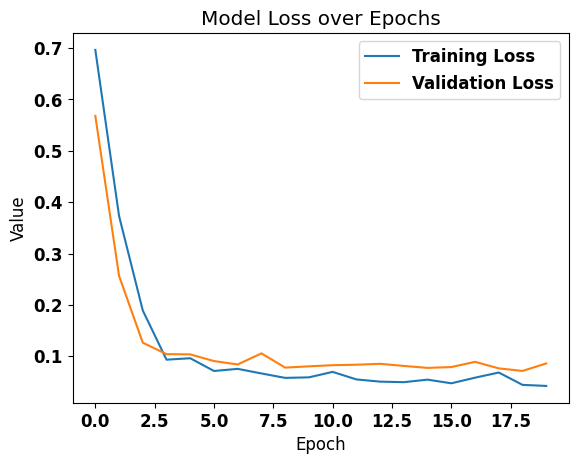

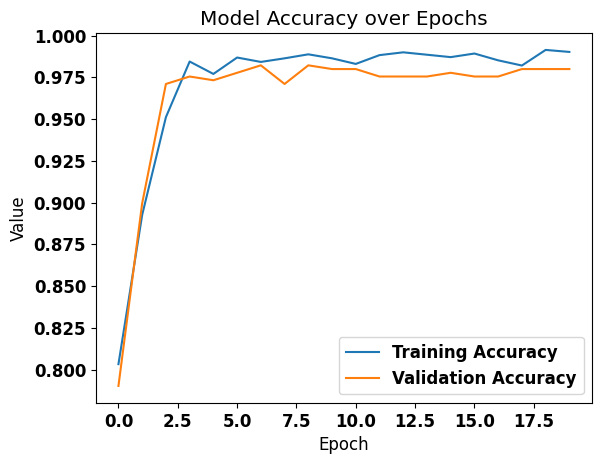

In [22]:
#use the model with best parameters
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(72, 48, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(72, 48, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
#L2 + Dropout
model.add(Dense(175, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.2))
model.add(Dense(175, activation='relu'))
model.add(Dense(3, activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

#train model
history = model.fit(X_train_inc, y_train_inc, epochs=20, batch_size=100, validation_data=(X_test, y_test), verbose=2)

#get the loss and accuracy and plot them against the number of epochs to see when it starts overfitting
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
fig, ax = plt.subplots()
ax.plot(history.history['loss'], label='Training Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.set_ylabel('Value')
ax.set_xlabel('Epoch')
ax.set_title('Model Loss over Epochs')
ax.legend()
plt.show()

fig, ay = plt.subplots()
ay.plot(history.history['accuracy'], label='Training Accuracy')
ay.plot(history.history['val_accuracy'], label='Validation Accuracy')
ay.set_ylabel('Value')
ay.set_xlabel('Epoch')
ay.set_title('Model Accuracy over Epochs')
ay.legend()
plt.show()


Based on the training history and the graph, the optimal accuracy with minimal loss is achieved when stopping after 9 epochs, effectively preventing overfitting.


# **6. Application on the test files**

## **6.1 Load test files**

In [23]:
test_data_directory = "/content/drive/MyDrive/Colab Notebooks/projet/MPA-MLF_DATA_NEW/Test"
test_file_list=sorted(os.listdir(test_data_directory), key=lambda x:int(re.search(r'\d+', x).group())) #list containing the names of the files in the directory : test_data_directory (in numerical order).
X_final= [np.load(os.path.join(test_data_directory, file)) for file in test_file_list] #load all .npy files into a list
y_final = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/projet/MPA-MLF_DATA_NEW/test_format.csv') #labels

## **6.2 Data preprocessing**
Before using the model on unseen data, we must preprocess it following the same steps we applied to the training data.

In [24]:
X_final=np.asarray(X_final)
X_final = X_final.astype('float32') / 255

#Reshape the data to add a channel dimension (for CNN input)
X_final=X_final.reshape(-1,72,48,1)

# **6.3 Model application**
We now apply the model with the best parameters found earlier and save the predictions to a file for Kaggle submission.

In [25]:
#use the model with best parameters
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(72, 48, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(72, 48, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
#L2 + Dropout
model.add(Dense(175, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.2))
model.add(Dense(175, activation='relu'))
model.add(Dense(3, activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

#train model
history = model.fit(X_train_inc, y_train_inc, epochs=9, batch_size=100, validation_data=(X_test, y_test), verbose=2)


#List of class labels
labels=['0', '1', '2']

#Make predictions on the test data
y_pred_final = model.predict(X_final)
y_pred_classes_final = np.argmax(y_pred_final, axis=1) #convert predictions to class labels

#save predictions into .csv file
y_final["target"]=y_pred_classes_final
y_final.to_csv('/content/drive/MyDrive/Colab Notebooks/projet/MPA-MLF_DATA_NEW/y_final_with_predictions.csv', index=False)



Epoch 1/9


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 - 17s - 411ms/step - accuracy: 0.8003 - loss: 0.7027 - val_accuracy: 0.8304 - val_loss: 0.5659
Epoch 2/9
42/42 - 15s - 357ms/step - accuracy: 0.9060 - loss: 0.3610 - val_accuracy: 0.8906 - val_loss: 0.2822
Epoch 3/9
42/42 - 15s - 357ms/step - accuracy: 0.9475 - loss: 0.1960 - val_accuracy: 0.9688 - val_loss: 0.1336
Epoch 4/9
42/42 - 20s - 481ms/step - accuracy: 0.9715 - loss: 0.1282 - val_accuracy: 0.9732 - val_loss: 0.1090
Epoch 5/9
42/42 - 21s - 491ms/step - accuracy: 0.9839 - loss: 0.0839 - val_accuracy: 0.9754 - val_loss: 0.0938
Epoch 6/9
42/42 - 21s - 491ms/step - accuracy: 0.9875 - loss: 0.0705 - val_accuracy: 0.9732 - val_loss: 0.0908
Epoch 7/9
42/42 - 21s - 489ms/step - accuracy: 0.9859 - loss: 0.0657 - val_accuracy: 0.9799 - val_loss: 0.0839
Epoch 8/9
42/42 - 15s - 359ms/step - accuracy: 0.9813 - loss: 0.0751 - val_accuracy: 0.9799 - val_loss: 0.0854
Epoch 9/9
42/42 - 15s - 354ms/step - accuracy: 0.9878 - loss: 0.0582 - val_accuracy: 0.9799 - val_loss: 0.0763
4/4 ━━━━━━━